### Тестовое задание, Трахов Роман

In [7]:
import numpy as np
from tqdm import tqdm_notebook as tqdm
import pandas as pd
import xgboost
import catboost
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn import metrics
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [8]:
data = pd.read_excel('sample.xlsx', sheet_name=0)
feature_desc = pd.read_excel('sample.xlsx', sheet_name=1)
task =  pd.read_excel('sample.xlsx', sheet_name=2)
start_columns = data.columns

In [9]:
data.head()

,customer_month_salary,sum_credit_current,term_credit_current,form,sphere,type,EDUCATION,age,marital_status,time_at_work,GENDER,month_passport_issued,month_with_bank,CITY,target,ID
0,52350.25,500000,59,ООО,"Наука, Образование, Здравоохранение",вспомогательный персонал,высшее,44,холост / не замужем,68.0,мужской,124,67.0,Москва,1,1
1,115000.00,400000,60,Иная форма,Другое,специалист,высшее,30,холост / не замужем,96.0,мужской,107,68.0,Москва,1,2
2,87000.00,361000,60,ОАО,"Финансы, управляющие компании, банки, страхование",специалист,Высшее/Второе высшее/Ученая степень,28,женат / замужем,117.0,женский,2,72.0,Москва,1,3
3,145358.17,1499000,60,ЗАО,"Финансы, управляющие компании, банки, страхование",менеджер среднего звена,Высшее/Второе высшее/Ученая степень,30,женат / замужем,35.0,мужской,124,70.0,Москва,1,4
4,50000.00,365000,60,ООО,Другое,специалист,среднее-специальное,31,холост / не замужем,48.0,мужской,131,88.0,Москва,1,5


In [10]:
data.describe()

,customer_month_salary,sum_credit_current,term_credit_current,age,time_at_work,month_passport_issued,month_with_bank,target,ID
count,4.730000e+03,4.771000e+03,4771.000000,4771.000000,4754.000000,4771.000000,3732.000000,4771.000000,4771.000000
mean,5.779673e+04,3.396049e+05,48.706141,36.961643,60.999159,92.163488,43.957663,0.329281,2386.000000
std,6.308617e+04,3.001721e+05,16.167960,9.373140,64.448633,48.746911,34.134775,0.470001,1377.413397
min,0.000000e+00,3.000000e+04,12.000000,22.000000,0.000000,0.000000,-1.000000,0.000000,1.000000
25%,2.800000e+04,1.510000e+05,36.000000,29.000000,15.000000,52.000000,17.000000,0.000000,1193.500000
50%,4.137263e+04,2.740000e+05,60.000000,35.000000,39.000000,93.000000,36.000000,0.000000,2386.000000
75%,6.500000e+04,4.400000e+05,60.000000,44.000000,82.000000,134.000000,62.000000,1.000000,3578.500000
max,1.357620e+06,8.000000e+06,84.000000,64.000000,478.000000,230.000000,200.000000,1.000000,4771.000000


In [11]:
task

,№,задание
0,1,построить аналитическую модель или модели (цел...
1,2,выбрать наилучшую модель. Объяснить свой выбор
2,3,все ли переменные вошили в финальную модель? П...


In [12]:
feature_desc

,название,описание
0,customer_month_salary,ежемесечный доход клиента
1,sum_credit_current,запрашиваемая сумма кредита
2,term_credit_current,срок запрашиваемого кредита
3,form,организационно-правовая форма работодателя
4,sphere,сфера деятельности клиента
5,type,тип должности
6,EDUCATION,образование
7,age,возраст клиента
8,marital_status,семейное положение
9,time_at_work,время работы на текущем месте работы


# Target

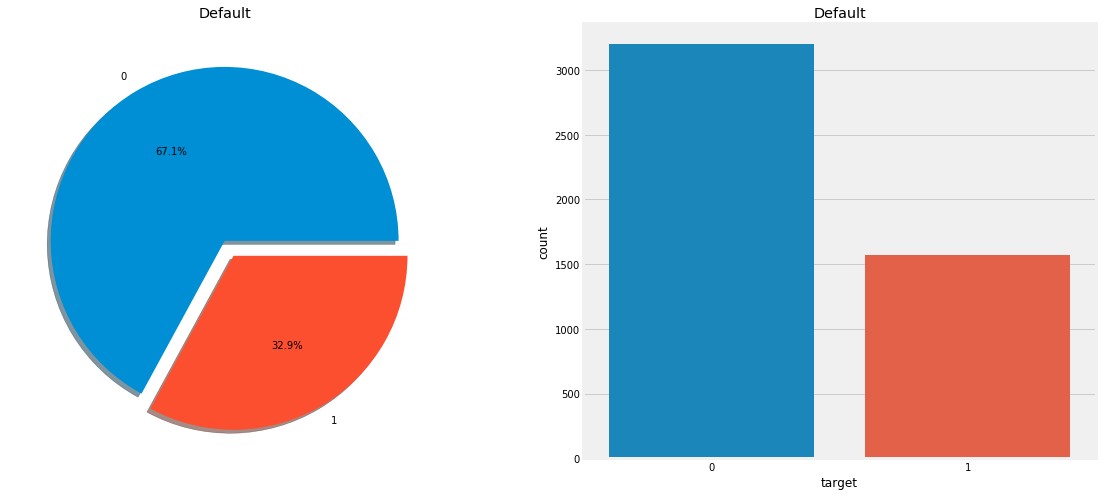

In [26]:
f,ax=plt.subplots(1,2,figsize=(18,8))
data['target'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Default')
ax[0].set_ylabel('')
sns.countplot('target',data=data,ax=ax[1])
ax[1].set_title('Default')
plt.show()

# Missing values in numerical features

In [14]:
data.columns

Index(['customer_month_salary', 'sum_credit_current', 'term_credit_current',
       'form', 'sphere', 'type', 'EDUCATION', 'age', 'marital_status',
       'time_at_work', 'GENDER', 'month_passport_issued', 'month_with_bank',
       'CITY', 'target', 'ID'],
      dtype='object')

In [15]:
categorical_features = ['form', 'sphere', 'type','marital_status','GENDER','CITY']
numeric_features = ['customer_month_salary', 'sum_credit_current', 'term_credit_current','age','month_passport_issued', 'month_with_bank']
# id не используем изначально

In [16]:
#Миссинги присутсвуют в полях: month_with_bank, customer_month_salary, time_at_work
features_with_mis = ['month_with_bank', 'customer_month_salary', 'time_at_work']
for feature in features_with_mis:
    data[feature+'_is_missing'] = data[feature].apply(lambda x: 1 if pd.isnull(x) else 0)

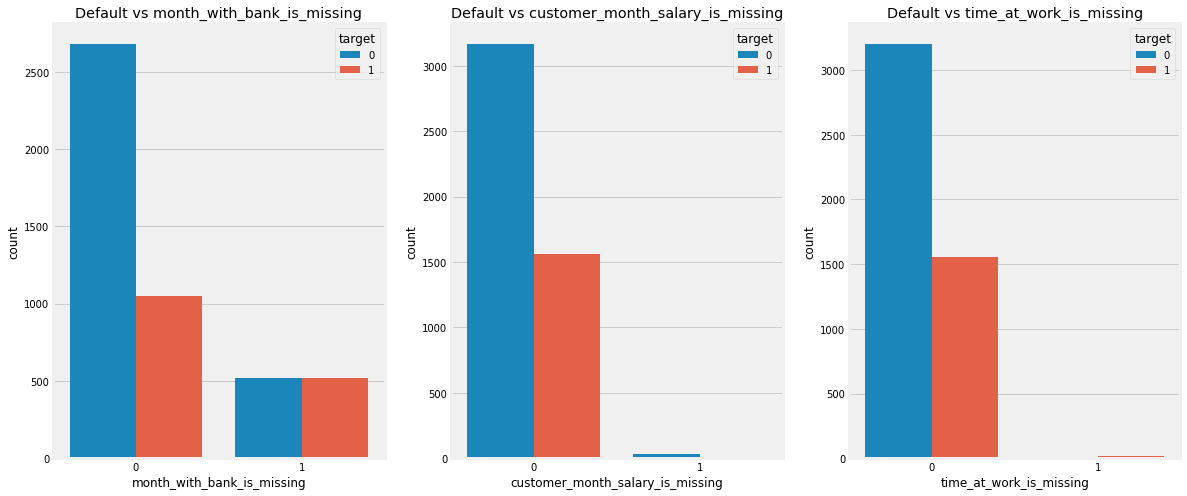

In [17]:
f,ax=plt.subplots(1,3,figsize=(18,8))
ax[0].set_title('Default vs month_with_bank_is_missing')
sns.countplot('month_with_bank_is_missing',hue='target',data=data,ax=ax[0])
ax[1].set_title('Default vs customer_month_salary_is_missing')
sns.countplot('customer_month_salary_is_missing',hue='target',data=data,ax=ax[1])
ax[2].set_title('Default vs time_at_work_is_missing')
sns.countplot('time_at_work_is_missing',hue='target',data=data,ax=ax[2])
plt.show()
# Количество миссингов значительно только для month_with_bank, его далее можно заменить на 0, что будет довольно логично (Иначе бы банк подтянул это поле из своей базы данных), далее мы это сделаем.

# Categorical features

### Gender

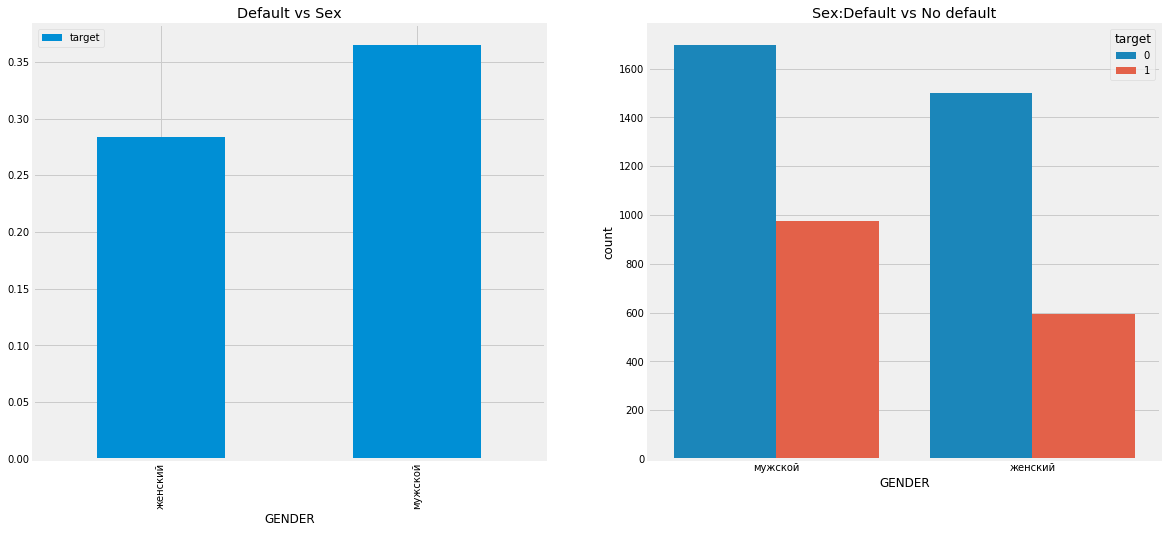

In [18]:
f,ax=plt.subplots(1,2,figsize=(18,8))
data[['GENDER','target']].groupby(['GENDER']).mean().plot.bar(ax=ax[0])
ax[0].set_title('Default vs Sex')
sns.countplot('GENDER',hue='target',data=data,ax=ax[1])
ax[1].set_title('Sex:Default vs No default')
plt.show()

In [19]:
# Мужчины на 5 процнетов чаще не возвращают кредит
# Добавим фичу пола
data['male'] = data.GENDER.apply(lambda x: 1 if x =='мужской' else 0)

### City

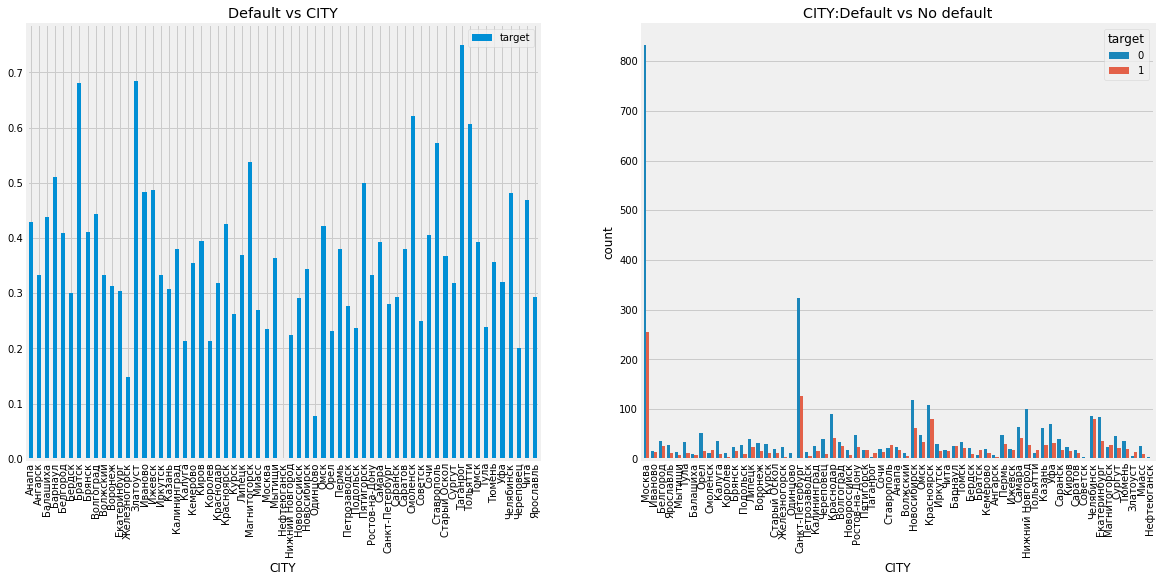

In [20]:
f,ax=plt.subplots(1,2,figsize=(18,8))
data[['CITY','target']].groupby(['CITY']).mean().plot.bar(ax=ax[0])
ax[0].set_title('Default vs CITY')
sns.countplot('CITY',hue='target',data=data,ax=ax[1])
ax[1].set_title('CITY:Default vs No default')
ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=90)
plt.show()
# Тут тоже есть явный разброс в разрезе кадого города (Единственное смущает, что у нас ОЧЕНЬ мало данных и по нескольким десяткам людей строить статистику не совсем верно)
# Поэтому построим новый признак Москва или Питер и все остальные. (Чтобы не переобучиться по этой фиче)
data['isMsk'] = data.CITY.apply(lambda x: 1 if x == 'Москва' or x == 'Санкт-Петербург' else 0)
numeric_features.append('isMsk')

### Education

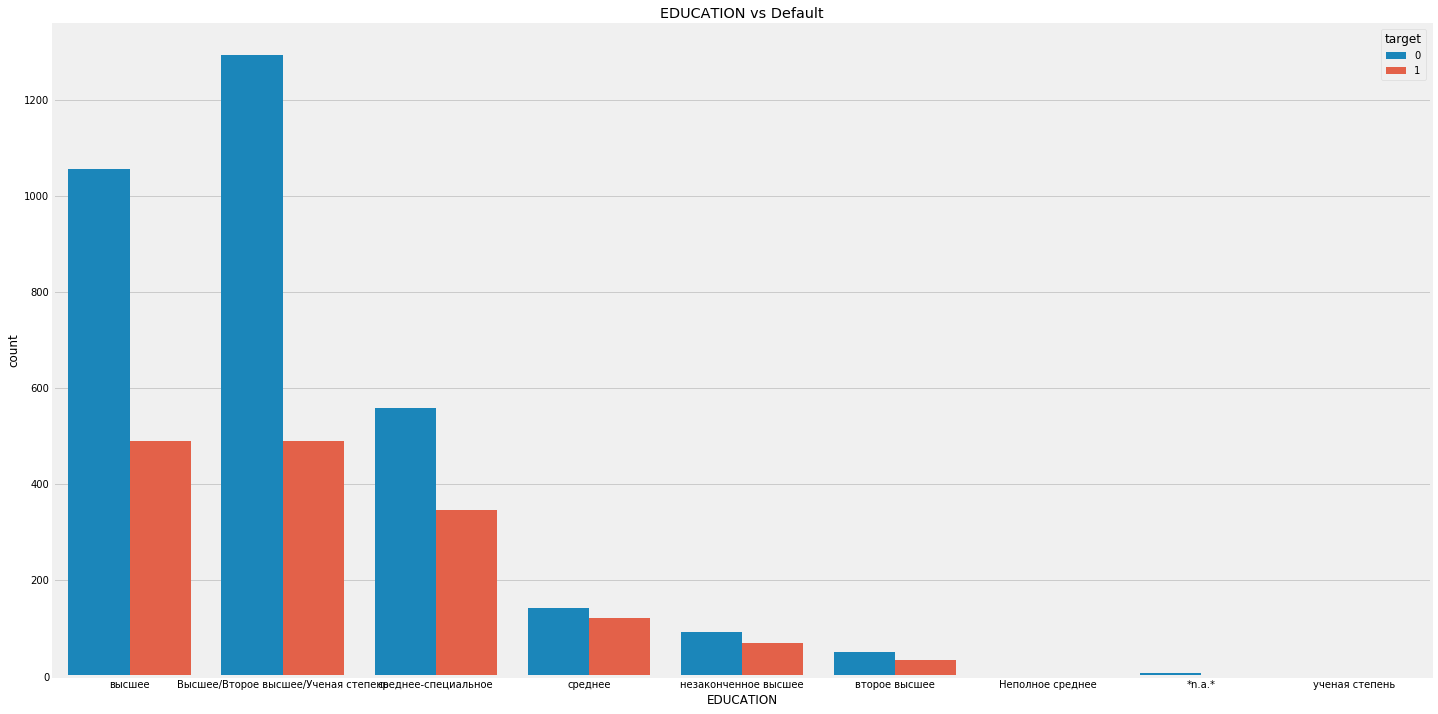

In [21]:
f,ax=plt.subplots(1,1,figsize=(22,12))
sns.countplot('EDUCATION',hue='target',data=data,orient = 'h')
plt.title('EDUCATION vs Default')
plt.show()

In [22]:
# Уменьшим количество различных вариантов образование, добавив варианты имеющие маленькое число наблюдений к наиболее похожим им.
def education(x):
    if x == '*n.a.*' or x == 'среднее' or x == 'Неполное среднее' or pd.isnull(x):
        return 1
    elif x == 'незаконченное высшее':
        return 2
    elif x == 'среднее-специальное':
        return 3
    elif x ==  'высшее':
        return 4
    elif x == 'Высшее/Второе высшее/Ученая степень' or x == 'второе высшее' or x == 'ученая степень':
        return 5  

In [23]:
data['education'] = data.EDUCATION.apply(lambda x: education(x))
numeric_features.append('education')

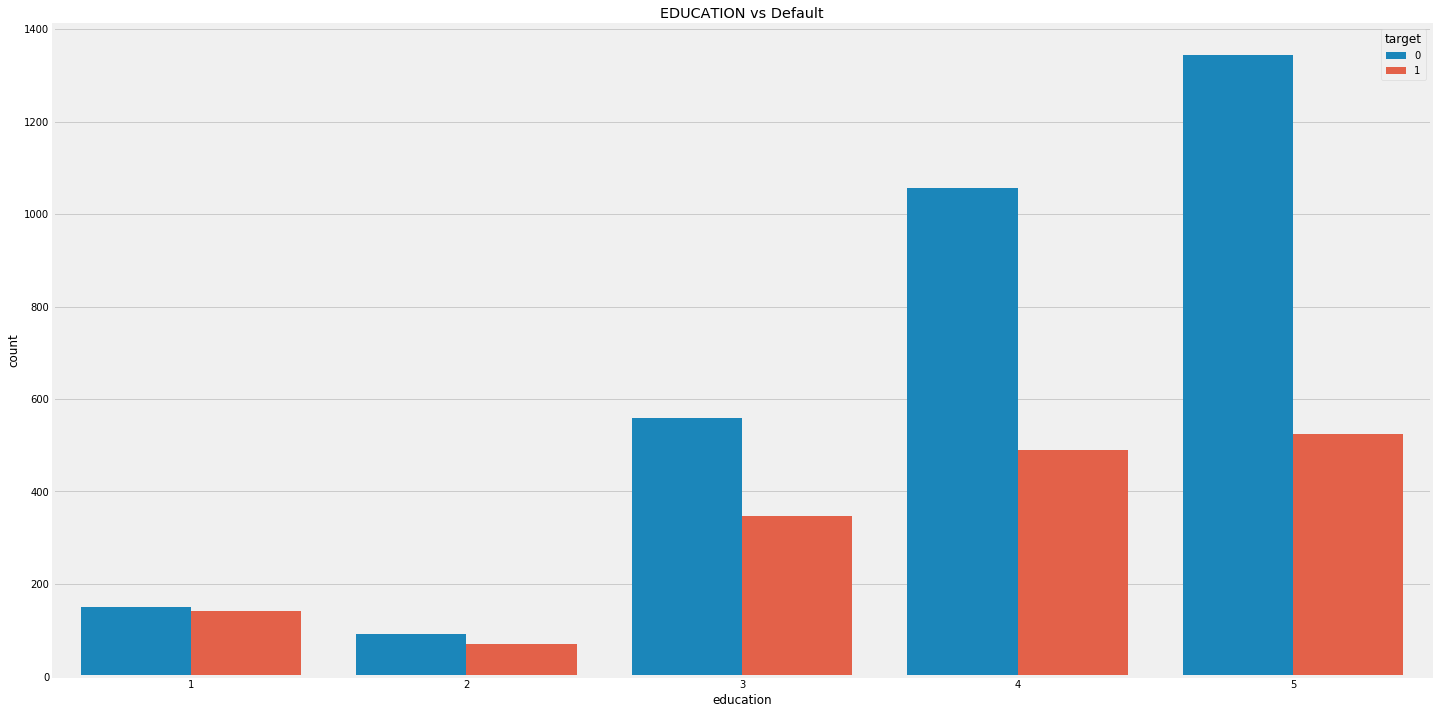

In [24]:
#так выглядит логичнее: больше образование-меньше вероятность дефолта
f,ax=plt.subplots(1,1,figsize=(22,12))
sns.countplot('education',hue='target',data=data,orient = 'h')
plt.title('EDUCATION vs Default')
plt.show()

### Marital_status

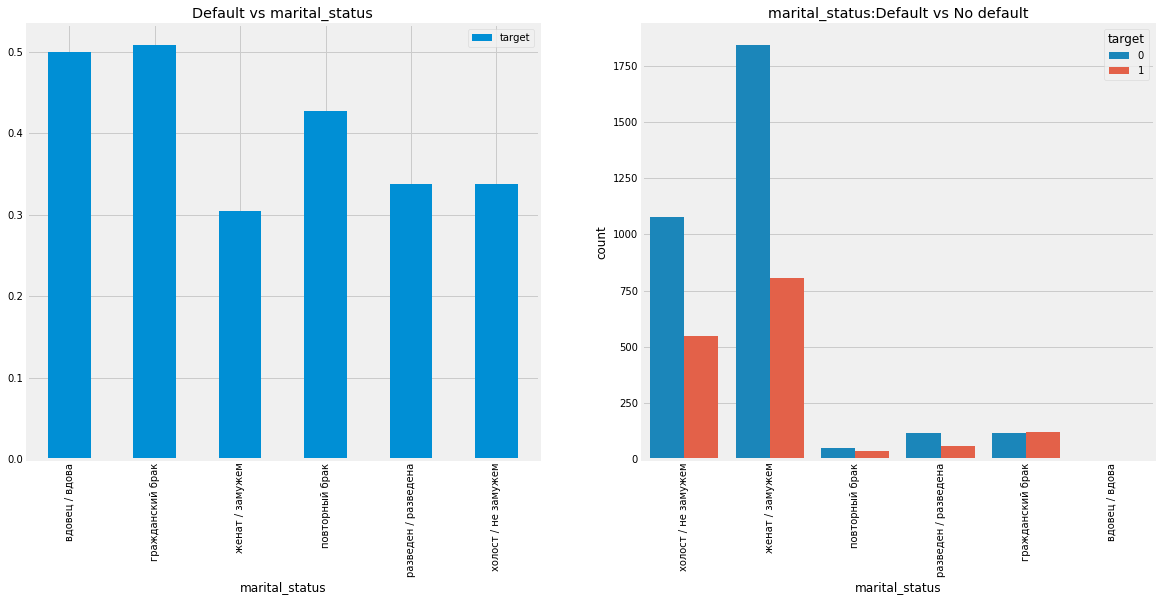

In [25]:
f,ax=plt.subplots(1,2,figsize=(18,8))
data[['marital_status','target']].groupby(['marital_status']).mean().plot.bar(ax=ax[0])
ax[0].set_title('Default vs marital_status')
sns.countplot('marital_status',hue='target',data=data,ax=ax[1])
ax[1].set_title('marital_status:Default vs No default')
ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=90)
plt.show()

### Form

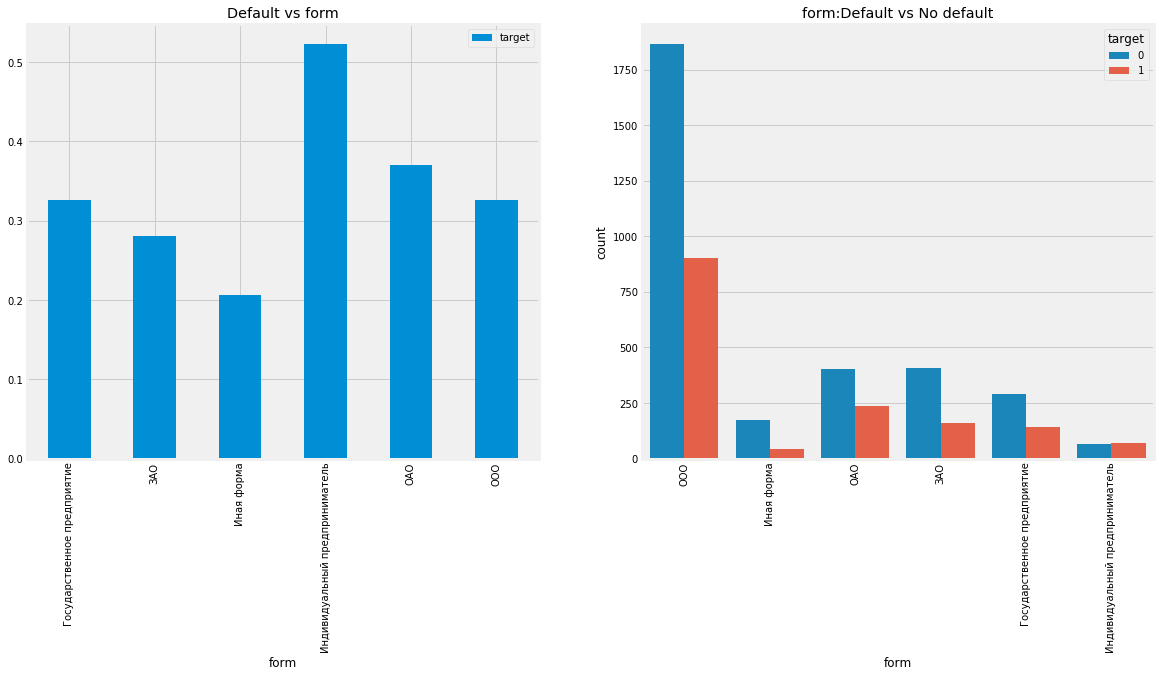

In [27]:
f,ax=plt.subplots(1,2,figsize=(18,8))
data[['form','target']].groupby(['form']).mean().plot.bar(ax=ax[0])
ax[0].set_title('Default vs form')
sns.countplot('form',hue='target',data=data,ax=ax[1])
ax[1].set_title('form:Default vs No default')
ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=90)
plt.show()
# Если учесть, что количество клиентов с 'Иной фирмой' и 'индивидуальный предприниматель' мало, 
#  то в целом можно говорить, что распределение внутри типа равномерное и этот признак не стоить учитывать при обучении

### Sphere

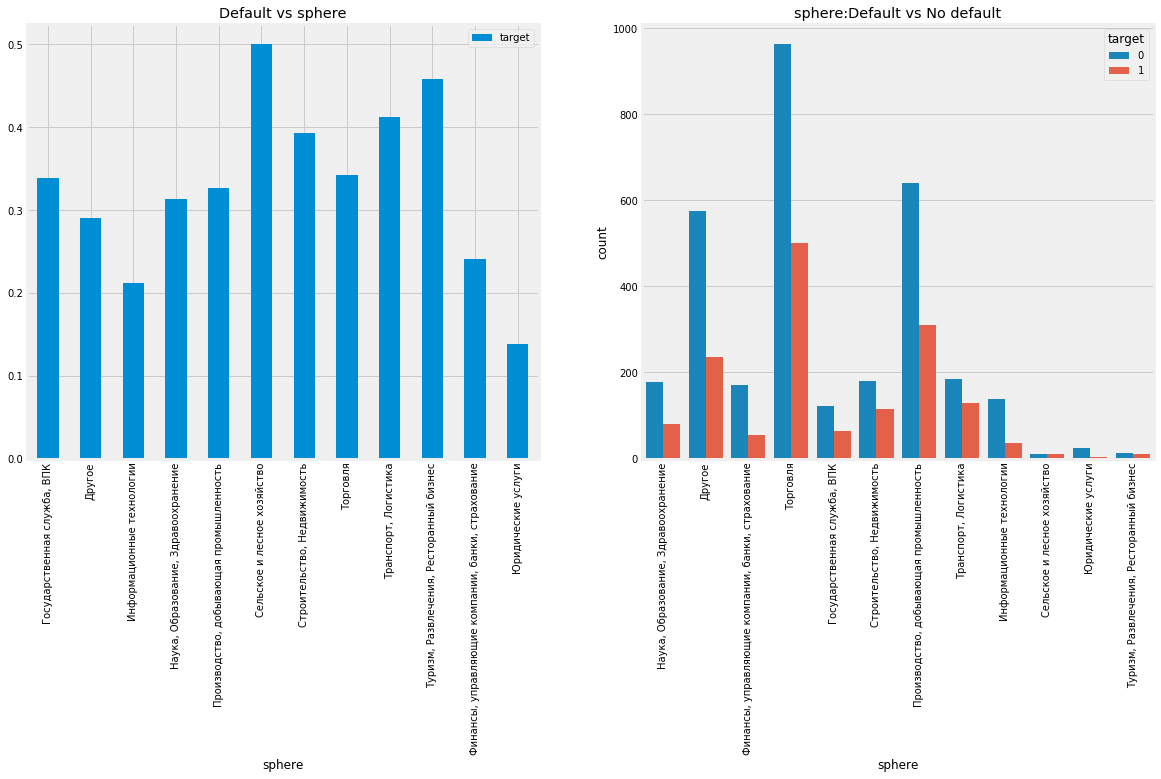

In [28]:
f,ax=plt.subplots(1,2,figsize=(18,8))
data[['sphere','target']].groupby(['sphere']).mean().plot.bar(ax=ax[0])
ax[0].set_title('Default vs sphere')
sns.countplot('sphere',hue='target',data=data,ax=ax[1])
ax[1].set_title('sphere:Default vs No default')
ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=90)
plt.show()
# Здесь тоже самое что с form: если убрать юридические услуги и сельское хозяйство
# (т.к. очень мало измерений, уж больно большая веротяность выбросов), то тут видим почти равномерное рспределение

### Type

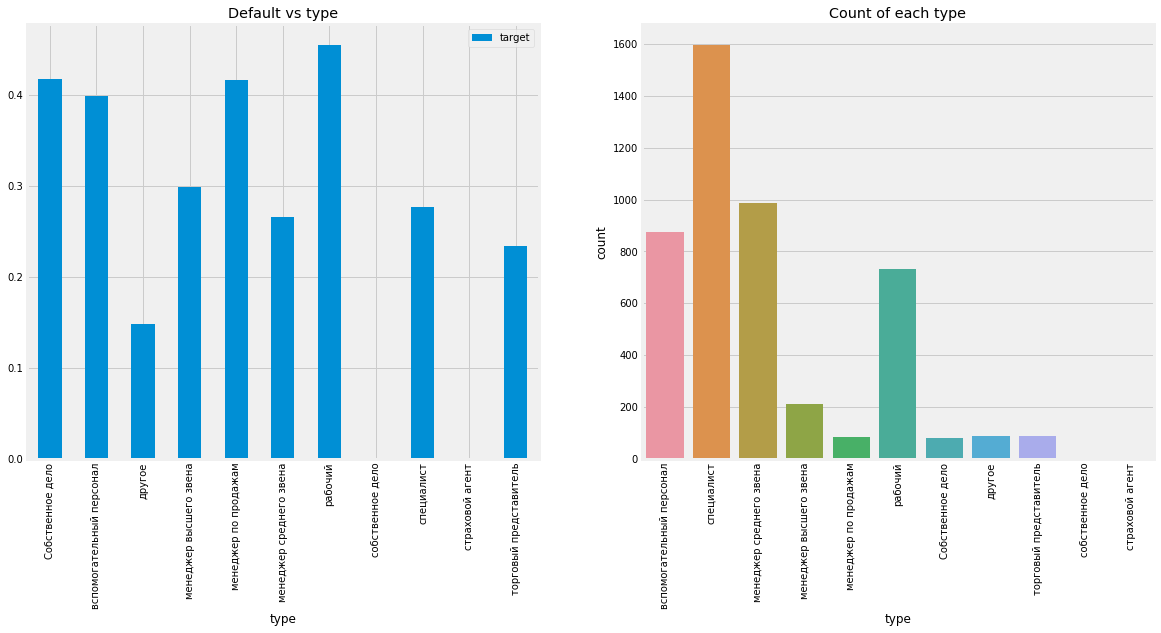

In [29]:
f,ax=plt.subplots(1,2,figsize=(18,8))
data[['type','target']].groupby(['type']).mean().plot.bar(ax=ax[0])
ax[0].set_title('Default vs type')
g = sns.countplot('type',data=data,ax=ax[1])
ax[1].set_title('Count of each type')
ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=90)
plt.show()

### Преобразуем категориальные фичи в likelihood smoothing

In [30]:
def smooth_mean_encoding(column, target, dataset, min_count = 10):
    dfavg = dataset[[column, target]][[column,target]].groupby([column]).mean()
    dfcount = pd.merge(dfavg , dataset[[column,target]].groupby([column]).count(), left_index=True, right_index=True, suffixes=('_mean', '_count'))
    dfcount['me'] = (dfcount[target+'_mean'].values * dfcount[target+'_count'].values + min_count * dataset[target].mean())/(dfcount[target+'_count'].values+min_count)
    dfcount[column] = dfcount.index
    return pd.merge(dataset,dfcount, on = column, how = 'left')['me'].fillna(dataset[target].mean()).values

In [31]:
for category in tqdm(categorical_features):
    data[category+'_me'] = smooth_mean_encoding(category, 'target', data, min_count = 25)
    numeric_features.append(category+'_me')

### Преобразуем численные фичи в N[0,1] и миссинги заменим нулями

In [32]:
cols = ['customer_month_salary', 'sum_credit_current', 'term_credit_current','age','month_passport_issued', 'month_with_bank', 'time_at_work']
data_normed = StandardScaler().fit_transform(data[cols].fillna(0))
data_n = pd.DataFrame(data_normed, columns = cols)
data_norm = data
data_norm[cols] = data_n

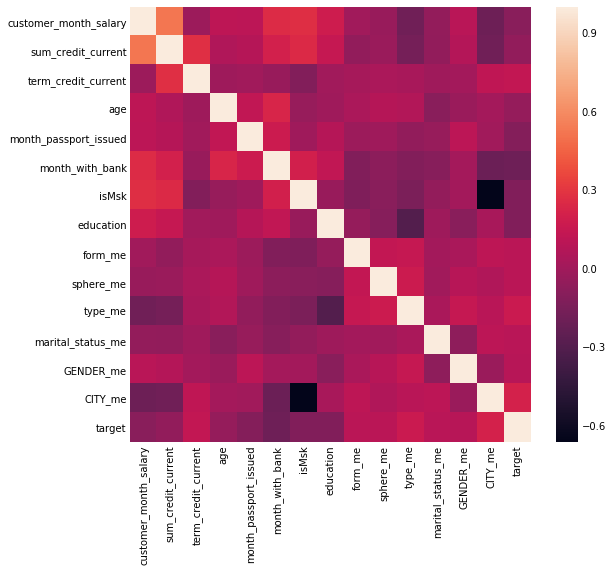

In [33]:
# посмотрим корреляции признаков
plt.figure(figsize=(8,8))
sns.heatmap(data_norm[numeric_features +['target']].corr())
#удалим CITY, т.к. ввели новый признак isMsk
numeric_features.remove('CITY_me')

In [46]:
#посмотрим коэффициенты регрессии с ridge регуляризацией
X = data_norm[numeric_features].drop(['sphere_me','type_me','form_me'], axis = 1)
y = data_norm["target"]
clf = RidgeClassifier().fit(X, y)

In [47]:
tuple(zip(list(X.columns),clf.coef_[0]))

(('customer_month_salary', 0.005691353487417),
 ('sum_credit_current', -0.028746100322783005),
 ('term_credit_current', 0.12303858934444815),
 ('age', 0.008788958525078668),
 ('month_passport_issued', -0.08014630353811475),
 ('month_with_bank', -0.13196245672436896),
 ('isMsk', -0.1442528282680697),
 ('education', -0.07445391608717894),
 ('marital_status_me', 1.6629572314144787),
 ('GENDER_me', 1.9833690185358746))

##### Не будем больше удалять признаки, хоть это и будет плохо для линейной модели, но мы надеемся на boosting и bagging.Ведь, возможно, там будут кросс зависимости типа: зарплата больше 100k и education = среднее, то не выдавать ну или что-то подобное. Пол не влияет непосредственно, но влияет вместе с семейным положением и возрастом.

### Train and Scoring

#### Обучим 3 модели: линейную с регуляризацией (logistic regression with ridge), бэггинговую (Random Forest Classifier) и бустинговую (xgbCLassifier)

###### Качество будем оценивать кроссвалидацией. Важно отметить, что чтобы не переобучиться каждый раз требуется пересчитывать значения категориальных признаков на обучающей выборке, иначе мы будем знать информацию из теста. Поэтому кросс валидацию необходимо реализовать самостоятельно.

In [85]:
# Сюда пишем любые модели, которые хоти использовать. (Я взял 3 простые модели с почти стандартным набором параметров)
def get_classifiers():
    lg = RidgeClassifier()
    rf = RandomForestClassifier(n_estimators=301, min_samples_leaf=3, min_samples_split=2)
    xgb = xgboost.XGBClassifier(n_estimators = 301)
    
    classifier_list = [lg,rf,xgb]
    classifier_results = np.array([np.array([]),np.array([]),np.array([])])
    classifier_targets = np.array([np.array([]),np.array([]),np.array([])])
    classifier_name_list = np.array(['LogisticRegression','RandomForest','Xgboost'])
    return classifier_list, classifier_name_list, classifier_results, classifier_targets

# Рассчет метрик
def append_evaluation_metrics(trained_model, trained_model_name, X_test,y_test):
    cr = [np.append(classifier_results[i], trained_model.predict(X_test)) if np.where(classifier_name_list == trained_model_name)[0][0] == i else classifier_results[i] for i in range(3)]
    ct = [np.append(classifier_targets[i], y_test) if np.where(classifier_name_list == trained_model_name)[0][0] == i else classifier_targets[i] for i in range(3)]
    return cr,ct

# Вывод результатов
def print_evaluation_metrics(trained_models,trained_model_names,classifier_results, classifier_targets):
    for trained_model,trained_model_name,classifier_result, classifier_target in zip(trained_models, trained_model_names,classifier_results, classifier_targets):
        print('--------- For Model : ', trained_model_name, ' ---------------\n')
        print(metrics.classification_report(classifier_target,classifier_result))
        print("accuracy score : ",metrics.accuracy_score(classifier_target,classifier_result))
        print("roc_auc score : ",metrics.roc_auc_score(classifier_target,classifier_result))
        print("---------------------------------------\n")

In [86]:
%%time
me_features = ['GENDER','isMsk', 'marital_status','education']
# фичи, которые попали в финальную модель
features = ['customer_month_salary', 'sum_credit_current', 'term_credit_current','month_passport_issued', 'age', 'month_with_bank', 'isMsk_me0',
             'education_me0', 'marital_status_me0', 'GENDER_me0']

classifier_list, classifier_name_list, classifier_results, classifier_targets = get_classifiers()
scores=[[],[],[]]
cr = []
ct = []

kf = KFold(n_splits = 3, shuffle = True, random_state = 17)

for train_index, test_index in tqdm(kf.split(data_norm)):
    X_train, X_test = pd.DataFrame(data_norm.values[train_index], columns = data_norm.columns), pd.DataFrame(data_norm.values[test_index], columns = data_norm.columns)
    y_train, y_test = data.target[train_index], data.target[test_index]
    
    #считаем фичи на трейне и джоиним к тесту
    X_train['target'] = y_train
    for category in tqdm(me_features):
        X_train[category+'_me0'] = smooth_mean_encoding(category, 'target', X_train, min_count = 25)
        X_test = pd.merge(X_test, X_train[[category, category+'_me0']].drop_duplicates(), on = category, how = 'left')
    for classifier,classifier_name,classifier_result, classifier_target in zip(classifier_list,classifier_name_list, classifier_results,classifier_targets):
        classifier.fit(X_train[features].values, y_train)
        classifier_results, classifier_targets = append_evaluation_metrics(classifier, classifier_name, X_test[features].values, y_test)
        cr.append(classifier_results)
        ct.append(classifier_targets)

CPU times: user 7.55 s, sys: 204 ms, total: 7.75 s
Wall time: 7.4 s


In [87]:
# точность
print_evaluation_metrics(classifier_list,classifier_name_list,classifier_results, classifier_targets)

--------- For Model :  LogisticRegression  ---------------

             precision    recall  f1-score   support

        0.0       0.69      0.95      0.80      3200
        1.0       0.57      0.15      0.23      1571

avg / total       0.65      0.68      0.61      4771

accuracy score :  0.6826661077342276
roc_auc score :  0.5461705323042648
---------------------------------------

--------- For Model :  RandomForest  ---------------

             precision    recall  f1-score   support

        0.0       0.72      0.89      0.80      3200
        1.0       0.56      0.28      0.37      1571

avg / total       0.67      0.69      0.66      4771

accuracy score :  0.6914692936491301
roc_auc score :  0.5864329049968173
---------------------------------------

--------- For Model :  Xgboost  ---------------

             precision    recall  f1-score   support

        0.0       0.72      0.87      0.79      3200
        1.0       0.54      0.31      0.40      1571

avg / total       

#### Что будет, если на тех же фолдах запустить CatBoost, со встроенным кодированием категориальных фичей(Оно похоже на то, что мы сами сделали руками) и отбором фичей :

In [88]:
%%time
preds = []
facts = []
kf = KFold(n_splits = 3, shuffle = True, random_state = 17)
for train_index, test_index in tqdm(kf.split(data)):
    cb = catboost.CatBoostClassifier(iterations = 301, cat_features=[3,4,5,6,8,10,13]).fit(data[start_columns].drop(['target','ID'], axis = 1).fillna('Nan').values[train_index],data['target'][train_index])
    preds.append(cb.predict(data[start_columns].drop(['target','ID'], axis = 1).fillna('Nan').values[test_index]))
    facts.append(data['target'][test_index])

0:	learn: 0.6807365	total: 36.8ms	remaining: 11s
1:	learn: 0.6682531	total: 80.5ms	remaining: 12s
2:	learn: 0.6568955	total: 128ms	remaining: 12.7s
3:	learn: 0.6463365	total: 173ms	remaining: 12.9s
4:	learn: 0.6387170	total: 215ms	remaining: 12.7s
5:	learn: 0.6316863	total: 258ms	remaining: 12.7s
6:	learn: 0.6277733	total: 302ms	remaining: 12.7s
7:	learn: 0.6220161	total: 359ms	remaining: 13.1s
8:	learn: 0.6165718	total: 451ms	remaining: 14.6s
9:	learn: 0.6124669	total: 481ms	remaining: 14s
10:	learn: 0.6080630	total: 536ms	remaining: 14.1s
11:	learn: 0.6046443	total: 582ms	remaining: 14s
12:	learn: 0.6013395	total: 628ms	remaining: 13.9s
13:	learn: 0.5971563	total: 689ms	remaining: 14.1s
14:	learn: 0.5939169	total: 737ms	remaining: 14.1s
15:	learn: 0.5909561	total: 787ms	remaining: 14s
16:	learn: 0.5885779	total: 833ms	remaining: 13.9s
17:	learn: 0.5860815	total: 877ms	remaining: 13.8s
18:	learn: 0.5849980	total: 941ms	remaining: 14s
19:	learn: 0.5823930	total: 994ms	remaining: 14s
20

163:	learn: 0.5238068	total: 7.01s	remaining: 5.86s
164:	learn: 0.5231955	total: 7.06s	remaining: 5.82s
165:	learn: 0.5225184	total: 7.1s	remaining: 5.78s
166:	learn: 0.5220465	total: 7.14s	remaining: 5.73s
167:	learn: 0.5217174	total: 7.19s	remaining: 5.69s
168:	learn: 0.5216259	total: 7.24s	remaining: 5.66s
169:	learn: 0.5213587	total: 7.29s	remaining: 5.62s
170:	learn: 0.5212405	total: 7.34s	remaining: 5.58s
171:	learn: 0.5211807	total: 7.38s	remaining: 5.54s
172:	learn: 0.5210733	total: 7.43s	remaining: 5.5s
173:	learn: 0.5203854	total: 7.48s	remaining: 5.46s
174:	learn: 0.5201658	total: 7.53s	remaining: 5.42s
175:	learn: 0.5196240	total: 7.57s	remaining: 5.38s
176:	learn: 0.5194861	total: 7.62s	remaining: 5.34s
177:	learn: 0.5193306	total: 7.67s	remaining: 5.3s
178:	learn: 0.5190808	total: 7.7s	remaining: 5.25s
179:	learn: 0.5186365	total: 7.75s	remaining: 5.21s
180:	learn: 0.5185962	total: 7.79s	remaining: 5.16s
181:	learn: 0.5180986	total: 7.83s	remaining: 5.12s
182:	learn: 0.51

21:	learn: 0.5919353	total: 1.03s	remaining: 13.1s
22:	learn: 0.5902629	total: 1.08s	remaining: 13.1s
23:	learn: 0.5888349	total: 1.13s	remaining: 13.1s
24:	learn: 0.5877224	total: 1.17s	remaining: 12.9s
25:	learn: 0.5860871	total: 1.22s	remaining: 12.9s
26:	learn: 0.5848378	total: 1.26s	remaining: 12.8s
27:	learn: 0.5842211	total: 1.29s	remaining: 12.6s
28:	learn: 0.5832121	total: 1.33s	remaining: 12.5s
29:	learn: 0.5828684	total: 1.36s	remaining: 12.3s
30:	learn: 0.5814203	total: 1.41s	remaining: 12.3s
31:	learn: 0.5813097	total: 1.44s	remaining: 12.1s
32:	learn: 0.5802761	total: 1.48s	remaining: 12s
33:	learn: 0.5793516	total: 1.52s	remaining: 11.9s
34:	learn: 0.5786432	total: 1.56s	remaining: 11.8s
35:	learn: 0.5780488	total: 1.59s	remaining: 11.7s
36:	learn: 0.5775969	total: 1.64s	remaining: 11.7s
37:	learn: 0.5767421	total: 1.69s	remaining: 11.7s
38:	learn: 0.5762961	total: 1.75s	remaining: 11.7s
39:	learn: 0.5753612	total: 1.78s	remaining: 11.6s
40:	learn: 0.5745179	total: 1.83s

181:	learn: 0.5323313	total: 7.82s	remaining: 5.11s
182:	learn: 0.5319797	total: 7.86s	remaining: 5.07s
183:	learn: 0.5319188	total: 7.91s	remaining: 5.03s
184:	learn: 0.5318814	total: 7.94s	remaining: 4.98s
185:	learn: 0.5318731	total: 7.97s	remaining: 4.93s
186:	learn: 0.5316907	total: 8.03s	remaining: 4.89s
187:	learn: 0.5312730	total: 8.08s	remaining: 4.85s
188:	learn: 0.5305160	total: 8.12s	remaining: 4.81s
189:	learn: 0.5299541	total: 8.18s	remaining: 4.78s
190:	learn: 0.5295308	total: 8.23s	remaining: 4.74s
191:	learn: 0.5295210	total: 8.27s	remaining: 4.7s
192:	learn: 0.5294222	total: 8.32s	remaining: 4.66s
193:	learn: 0.5292388	total: 8.38s	remaining: 4.62s
194:	learn: 0.5289080	total: 8.43s	remaining: 4.58s
195:	learn: 0.5285029	total: 8.47s	remaining: 4.54s
196:	learn: 0.5276235	total: 8.52s	remaining: 4.5s
197:	learn: 0.5267464	total: 8.57s	remaining: 4.46s
198:	learn: 0.5265453	total: 8.62s	remaining: 4.42s
199:	learn: 0.5265448	total: 8.64s	remaining: 4.37s
200:	learn: 0.

42:	learn: 0.5548693	total: 2.3s	remaining: 13.8s
43:	learn: 0.5544739	total: 2.34s	remaining: 13.7s
44:	learn: 0.5537758	total: 2.4s	remaining: 13.6s
45:	learn: 0.5531587	total: 2.45s	remaining: 13.6s
46:	learn: 0.5528845	total: 2.48s	remaining: 13.4s
47:	learn: 0.5522660	total: 2.53s	remaining: 13.4s
48:	learn: 0.5514481	total: 2.58s	remaining: 13.3s
49:	learn: 0.5510499	total: 2.63s	remaining: 13.2s
50:	learn: 0.5495591	total: 2.69s	remaining: 13.2s
51:	learn: 0.5492168	total: 2.73s	remaining: 13.1s
52:	learn: 0.5491124	total: 2.76s	remaining: 12.9s
53:	learn: 0.5486840	total: 2.81s	remaining: 12.8s
54:	learn: 0.5484004	total: 2.84s	remaining: 12.7s
55:	learn: 0.5479735	total: 2.91s	remaining: 12.7s
56:	learn: 0.5473513	total: 2.95s	remaining: 12.6s
57:	learn: 0.5466521	total: 3s	remaining: 12.6s
58:	learn: 0.5461715	total: 3.05s	remaining: 12.5s
59:	learn: 0.5453344	total: 3.11s	remaining: 12.5s
60:	learn: 0.5450609	total: 3.14s	remaining: 12.4s
61:	learn: 0.5448038	total: 3.18s	re

202:	learn: 0.4997963	total: 10.3s	remaining: 4.97s
203:	learn: 0.4992851	total: 10.4s	remaining: 4.92s
204:	learn: 0.4990560	total: 10.4s	remaining: 4.87s
205:	learn: 0.4990122	total: 10.5s	remaining: 4.82s
206:	learn: 0.4984282	total: 10.5s	remaining: 4.77s
207:	learn: 0.4974623	total: 10.6s	remaining: 4.73s
208:	learn: 0.4974123	total: 10.6s	remaining: 4.67s
209:	learn: 0.4964008	total: 10.7s	remaining: 4.63s
210:	learn: 0.4959257	total: 10.8s	remaining: 4.59s
211:	learn: 0.4958910	total: 10.8s	remaining: 4.53s
212:	learn: 0.4957232	total: 10.9s	remaining: 4.49s
213:	learn: 0.4952663	total: 10.9s	remaining: 4.44s
214:	learn: 0.4951348	total: 11s	remaining: 4.39s
215:	learn: 0.4951279	total: 11s	remaining: 4.34s
216:	learn: 0.4948235	total: 11.1s	remaining: 4.29s
217:	learn: 0.4939199	total: 11.1s	remaining: 4.23s
218:	learn: 0.4936204	total: 11.2s	remaining: 4.18s
219:	learn: 0.4926775	total: 11.2s	remaining: 4.13s
220:	learn: 0.4926074	total: 11.3s	remaining: 4.08s
221:	learn: 0.49

In [89]:
# точность
print(metrics.classification_report([item for sublist in facts for item in sublist], [item for sublist in preds for item in sublist]))
print('roc_auc = '+ str(metrics.roc_auc_score([item for sublist in facts for item in sublist], [item for sublist in preds for item in sublist])))
# получаем такой же roc_auc, но чуть меньший recall, в целом это объясняется что мы руками сделал

             precision    recall  f1-score   support

          0       0.72      0.91      0.80      3200
          1       0.60      0.28      0.38      1571

avg / total       0.68      0.70      0.66      4771

roc_auc = 0.5945925167091025


# Ответы на вопросы:

### 1. Построить аналитическую модель или модели.
##### Я построил 3 базовые модели (линейную, бэгинговую и бустинговую) + бонусный catboost на изначальных признаках
### 2.Выбрать наилучшую модель. Объяснить свой выбор
##### Из этих 3 моделей стоит выбрать xgboost, т.к. она дает наибольшую точноть на кросс валидации и по recall и по roc_auc.
### 3.Все ли фичи вошли?
##### Нет, не все фичи вошли, какието были преобразованы (образование (чтобы убрать редко-встречающиеся образования и объеденить их с более популярными (чтобы не переобучиться)) и город, т.к. количество наблюдений для некоторых городов слишком мало, для объективной оценки). Еще я убрал type, sphere и form, т.к. рспределние доли невозвратов в этих категорий имеет почти равномерное распределение. 

## Как улучшить:
###### 1. Настроить параметры у моделей
###### 2. Вместо фичи isMsk сделать сегментацию городов, потому что среди мальньких городов наверняка есть хорошие и плохие.
###### 3. Для каждой модели нужно отбирать фичи отдельно под эту модель, если для современных бустингов это можно не делать (т.к. внутри зашиты регуляризации), то для линейной модели это необходимо. Также в случае линейной модели, нужно добавлять кросс признаки самостоятельно и смотреть их важность, это также может улучшить точность.
###### 4. Добавить новые фичи, типа Зарплата_в_месяц - ежемесячный_платеж, наверняка у такого признака будет большая зависимость с таргетом по сравнению с размером кредита или зарплатой по отдельности.